# Load libraries and Data

In [1]:
from pyhive import presto

def get_presto_conn():
    # need to impersonate to the owner to drop exisiting tables
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086, username='shahidhya')

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# MP mWeb Non-sticky Checkout V1

In [2]:
# latest ramp period
start_date = '2022-05-12'
end_date = '2022-05-18'
test_name = 'mp_mweb_non_sticky_checkout_v1'
control = 'control'
treatment = 'treatment'
# device_cat = "('Personal computer')" 
device_cat = "('Tablet','Smartphone')"
tmp_visitor_base = 'wandajuan.visitor_base_' + test_name
tmp_mp_metrics = 'wandajuan.mp_metrics_' + test_name
tmp_xo_metrics = 'wandajuan.xo_metrics_' + test_name
tmp_xo_funnels = 'wandajuan.xo_funnel_action_' + test_name
tmp_final_table = 'wandajuan.' + test_name

## User Base

In [3]:
# Test user base:

q = """DROP TABLE IF EXISTS {tmp_visitor_base}""".format(tmp_visitor_base=tmp_visitor_base)
print(pd.read_sql(q, conn))

print('run query below in presto:')


q = """
CREATE TABLE {tmp_visitor_base} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%{test_name}=%') 
                          and device_cat in {device_cat}
                          and session_id not in (
                                            select session_id 
                                            from l2.session_summary 
                                            where user_agent like '%test_automation%' 
                                            and dt>= '{start_date}') 
                      )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_visitor_base=tmp_visitor_base,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,2653


In [4]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_visitor_base} group by 1 order by 1""".format(tmp_visitor_base=tmp_visitor_base),conn)

,test_variant,_col1
0,control,1330
1,treatment,1323


with or without dedup, total # visitors in manual pull is more than abdash, which is 1155, 1131

In [5]:
test_users = pd.read_sql('select * from {tmp_visitor_base}'.format(tmp_visitor_base=tmp_visitor_base), conn)
test_users

,visitor_id,test_variant,dt
0,fdf561c3-59cd-4fe2-97d6-339323f95f0f,control,2022-05-14
1,54fd47f0-55a0-4e46-a42a-6786ba98b6dd,treatment,2022-05-14
2,eb5ec387-d6ff-4b34-b135-08866d16760a,treatment,2022-05-14
3,3c466ce4-1d6e-4da6-9580-cfbdb79c641b,treatment,2022-05-12
4,a287c37f-3893-4fc9-94f7-7f7f6d881dbc,treatment,2022-05-16
...,...,...,...
2648,b3b2abc7-b0ed-4119-ab62-d5ec4a198fb6,control,2022-05-17
2649,92beae6b-1b0a-41cb-8325-4d2fcf8aa26e,control,2022-05-13
2650,4fc62a59-04b1-4736-adaa-155442ec1ff6,treatment,2022-05-15
2651,021d4df8-3f10-4585-8c81-37db61aa8a64,treatment,2022-05-15


## MP table

In [6]:
# MP Metrics: since there are not that many rows - 2K+ -> pull the entire pos
print(pd.read_sql('drop table if exists {tmp_mp_metrics}'.format(tmp_mp_metrics=tmp_mp_metrics), conn))


print('run query below in presto:')

q = """
CREATE TABLE {tmp_mp_metrics} AS

select 
		t0.*,
		t2.order_date, 
		t2.order_id,
		t2.created,
		t2.status,
		t2.item_id, 
		t2.house_id,
		t2.item_gmv,
		t2.init_item_commission,
		t2.gmv_net_of_returns,
		t2.net_commission,
		t2.placed_order_item_coupon_amount,
		t2.is_trade_program,
		t2.session_id,
		t2.medium,
		t2.l1_category,
		t2.browser,
		t2.os,
		t2.device_cat,
		t2.channel,
		t2.new_visitor,
		t2.landing_page_class,
		
		( case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
		( case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
		( case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
		( case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
		( case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
		( case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
		( case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
		( case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv
from {tmp_visitor_base} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0
  -- not excluding trade orders 
--  and is_trade_program = 0
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_mp_metrics = tmp_mp_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

   result
0    True
run query below in presto:


,rows
0,850


In [8]:
# mp = pd.read_sql("select * from {tmp_mp_metrics}".format(tmp_mp_metrics=tmp_mp_metrics), conn)
# mp

## XO Table

In [9]:
# Checkout Metrics:

pd.read_sql('drop table if exists {tmp_xo_metrics}'.format(tmp_xo_metrics=tmp_xo_metrics), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_xo_metrics} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*
from {tmp_visitor_base} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_xo_metrics = tmp_xo_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,7161


In [12]:
# xo = pd.read_sql("select * from {tmp_xo_metrics}".format(tmp_xo_metrics = tmp_xo_metrics), conn)
# xo

## XO funnel actions

In [11]:

# Checkout funnel with sign in status at the time of performing checkout actions:
print(pd.read_sql('drop table if exists {tmp_xo_funnels}'.format(tmp_xo_funnels=tmp_xo_funnels), conn))

print('run query below in presto:')

q = """
CREATE TABLE {tmp_xo_funnels} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*,
	coalesce(json_extract_scalar(action_metadata, '$.app'), json_extract_scalar(action_metadata, '$.originatingPageData["app"]'))  app,
	coalesce(json_extract_scalar(action_metadata, '$.isUserSignedIn'), json_extract_scalar(action_metadata, '$.originatingPageData["isUserSignedIn"]'))  isUserSignedIn	
from {tmp_visitor_base} t0
join l2.user_action_daily t2
on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
and (t2.action like '%CHECKOUT%' 
--or t2.action like '%CART%'
--or t2.action like '%SIGN%'
)
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_xo_funnels = tmp_xo_funnels,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

   result
0    True
run query below in presto:


,rows
0,5519


In [13]:
xo_action = pd.read_sql("select * from {tmp_xo_funnels}".format(tmp_xo_funnels=tmp_xo_funnels), conn)
# xo_action

## Final Table

In [14]:
# Final Table:
pd.read_sql('drop table if exists {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)

print('run query below in presto:')

q = """
CREATE TABLE {tmp_final_table} AS

with xo as (

select dt, test_variant, visitor_id, 

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3

)
, mp as (

select order_date, test_variant, visitor_id,

	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3
)
select 
		coalesce(order_date, dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
""".format(tmp_xo_metrics=tmp_xo_metrics,
           tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics,
            tmp_visitor_base=tmp_visitor_base,
            start_date=start_date,
            end_date=end_date)


# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,4016


In [15]:
df = pd.read_sql('select * from {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)
df

,dt,test_variant,visitor_id,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-15,control,05131d1e-ae02-43e3-b3b8-bff12632f3e0,17,24,1,2,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-15,control,0f62924f-1eaf-4a80-8d16-59b43ca9bcb1,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-15,treatment,47941ada-f40b-4dfa-9f20-bbdeafeb339b,0,1,1,0,1,1,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-15,treatment,ab0c499b-0cc7-4df7-86d6-83bd154a5a0f,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-17,control,f3d11c38-36c5-4b8c-8b5e-3026b11cc761,0,5,1,2,1,2,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4011,2022-05-18,control,839ad43c-8055-47cf-a837-5f4db85c0036,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4012,2022-05-13,control,920d8f02-3464-45e7-977e-2ac1840741eb,0,4,0,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4013,2022-05-18,control,e3b64f60-becb-418e-8eed-9a793a339699,2,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4014,2022-05-18,control,089a8377-d8c1-4928-9403-739a1c1425a1,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Helper functions

In [16]:
def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df
def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

In [17]:
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)]['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)]['visitors'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric]
        trt = input_df[(input_df['test_variant'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == control)][metric]*input_df[(input_df['test_variant'] == control)]['visitors']).sum()
        trt_total = (input_df[(input_df['test_variant'] == treatment)][metric]*input_df[(input_df['test_variant'] == treatment)]['visitors']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

# Analysis

## User distribution

In [18]:
df.groupby('test_variant')['visitor_id'].nunique()

test_variant
control      1330
treatment    1323
Name: visitor_id, dtype: int64

In [19]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique')

test_variant,control,treatment
dt,,
2022-05-12,223,190
2022-05-13,229,219
2022-05-14,274,281
2022-05-15,313,334
2022-05-16,308,354
2022-05-17,316,308
2022-05-18,334,333


<AxesSubplot:xlabel='dt'>

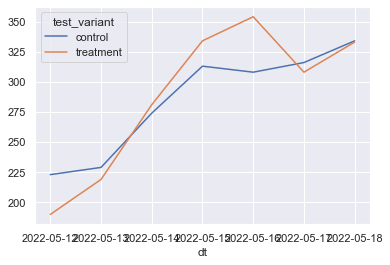

In [20]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique').plot()

## Remove outliers

In [21]:
# exclude qa
df = df.loc[~df['test_variant'].str.contains('qa')]

In [22]:
df[['dt', 'test_variant', 'visitor_id', 'order_gmv']].sort_values(by='order_gmv', ascending=False)

,dt,test_variant,visitor_id,order_gmv
381,2022-05-15,treatment,37d95fa1-b6ea-4673-8e3c-6465ab2a03b1,5758.00
253,2022-05-14,control,ec85a4f7-affb-4261-acae-8ee63fe0fce2,5737.00
1269,2022-05-17,control,869f5d84-87bc-4d3a-a9d1-727500b203b7,4750.00
259,2022-05-17,treatment,dd3d248e-9bc0-4a37-aa67-065211bb5c8c,4309.99
1314,2022-05-16,treatment,4011a090-68ba-49b0-b62f-39eeab1023be,3538.00
...,...,...,...,...
4011,2022-05-18,control,839ad43c-8055-47cf-a837-5f4db85c0036,NaN
4012,2022-05-13,control,920d8f02-3464-45e7-977e-2ac1840741eb,NaN
4013,2022-05-18,control,e3b64f60-becb-418e-8eed-9a793a339699,NaN
4014,2022-05-18,control,089a8377-d8c1-4928-9403-739a1c1425a1,NaN


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_gmv', ylabel='Density'>

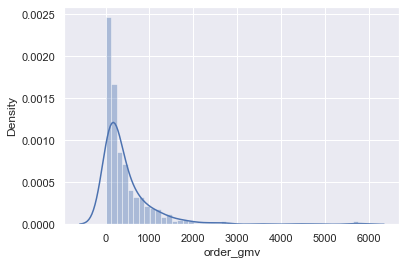

In [23]:
sns.distplot(df['order_gmv'])

<Figure size 1152x288 with 0 Axes>

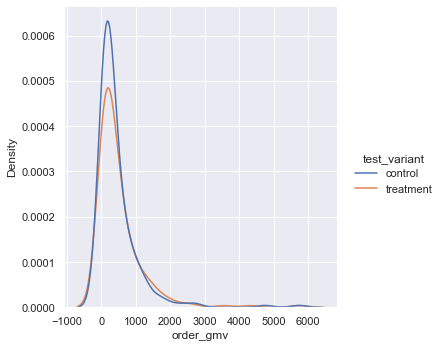

In [24]:
plt.figure(figsize=(16,4)) 
sns.displot(data=df, x='order_gmv', hue='test_variant', kind='kde')

In [25]:
# for some reason, treatment seems to have more large gmv orders
df.loc[df['order_gmv']>3000]['test_variant'].value_counts()

treatment    3
control      2
Name: test_variant, dtype: int64

In [26]:
# excluding 0 large order from control
df = df.loc[df['order_gmv']<10000]

In [27]:
metrics = df.columns[3:]
# df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique())
dtd_metrics = df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique()).reset_index()
dtd_metrics

,dt,test_variant,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-12,control,9.533333,6.666667,1.266667,2.333333,1.600000,1.533333,1.233333,2.100000,1.100000,0.866667,1.166667,2.800000,487.769667,486.436333,113.171060,111.837727,0.800000,0.366667,0.966667,0.0,0.000000,0.200000,404.687667,0.0,0.000000,83.082000
1,2022-05-12,treatment,4.100000,6.266667,1.533333,2.900000,1.766667,1.533333,1.266667,1.700000,1.166667,0.400000,1.200000,1.966667,502.555000,491.138667,105.448693,94.032360,0.700000,0.500000,0.900000,0.0,0.033333,0.266667,419.489333,0.0,2.866667,80.199000
2,2022-05-13,control,5.740741,4.222222,1.148148,2.111111,1.592593,1.555556,1.481481,1.555556,1.000000,0.851852,1.148148,1.259259,205.184815,203.496667,48.437407,46.749259,0.814815,0.333333,0.629630,0.0,0.074074,0.444444,120.997037,0.0,17.592222,66.595556
3,2022-05-13,treatment,7.153846,6.230769,1.269231,2.923077,1.730769,1.807692,1.384615,1.769231,1.038462,0.692308,1.115385,1.461538,257.566538,256.028077,52.164877,50.626415,0.730769,0.384615,0.500000,0.0,0.038462,0.576923,206.396538,0.0,2.453846,48.716154
4,2022-05-14,control,8.342105,5.026316,1.184211,2.657895,1.684211,1.526316,1.105263,1.631579,1.131579,0.605263,1.184211,1.973684,437.911842,432.253947,112.457421,106.799526,0.842105,0.342105,0.763158,0.0,0.052632,0.368421,367.424211,0.0,19.197632,51.290000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2022-05-16,treatment,7.156250,9.375000,1.156250,3.375000,1.687500,1.750000,1.406250,1.718750,1.031250,0.562500,1.062500,1.812500,596.040313,593.540313,160.288775,157.788775,0.718750,0.343750,0.781250,0.0,0.000000,0.281250,501.349688,0.0,0.000000,94.690625
10,2022-05-17,control,3.736842,6.052632,1.131579,2.921053,1.657895,1.526316,1.342105,2.000000,1.078947,0.552632,1.184211,2.710526,681.662632,655.942632,162.021105,136.301105,0.500000,0.684211,0.763158,0.0,0.000000,0.421053,352.416842,0.0,0.000000,329.245789
11,2022-05-17,treatment,3.400000,5.500000,1.400000,2.850000,1.750000,1.800000,1.650000,1.700000,1.550000,0.350000,1.150000,1.850000,872.908500,868.908500,196.019000,192.019000,0.750000,0.400000,0.950000,0.0,0.000000,0.200000,718.158500,0.0,0.000000,154.750000
12,2022-05-18,control,5.000000,5.750000,1.178571,2.464286,1.357143,1.321429,1.178571,1.392857,1.000000,0.785714,1.071429,1.785714,443.614286,440.757143,98.288371,95.431229,0.785714,0.285714,0.821429,0.0,0.000000,0.250000,286.063214,0.0,0.000000,157.551071


## Day to Day Metrics Plot

In [28]:
len(metrics)

26

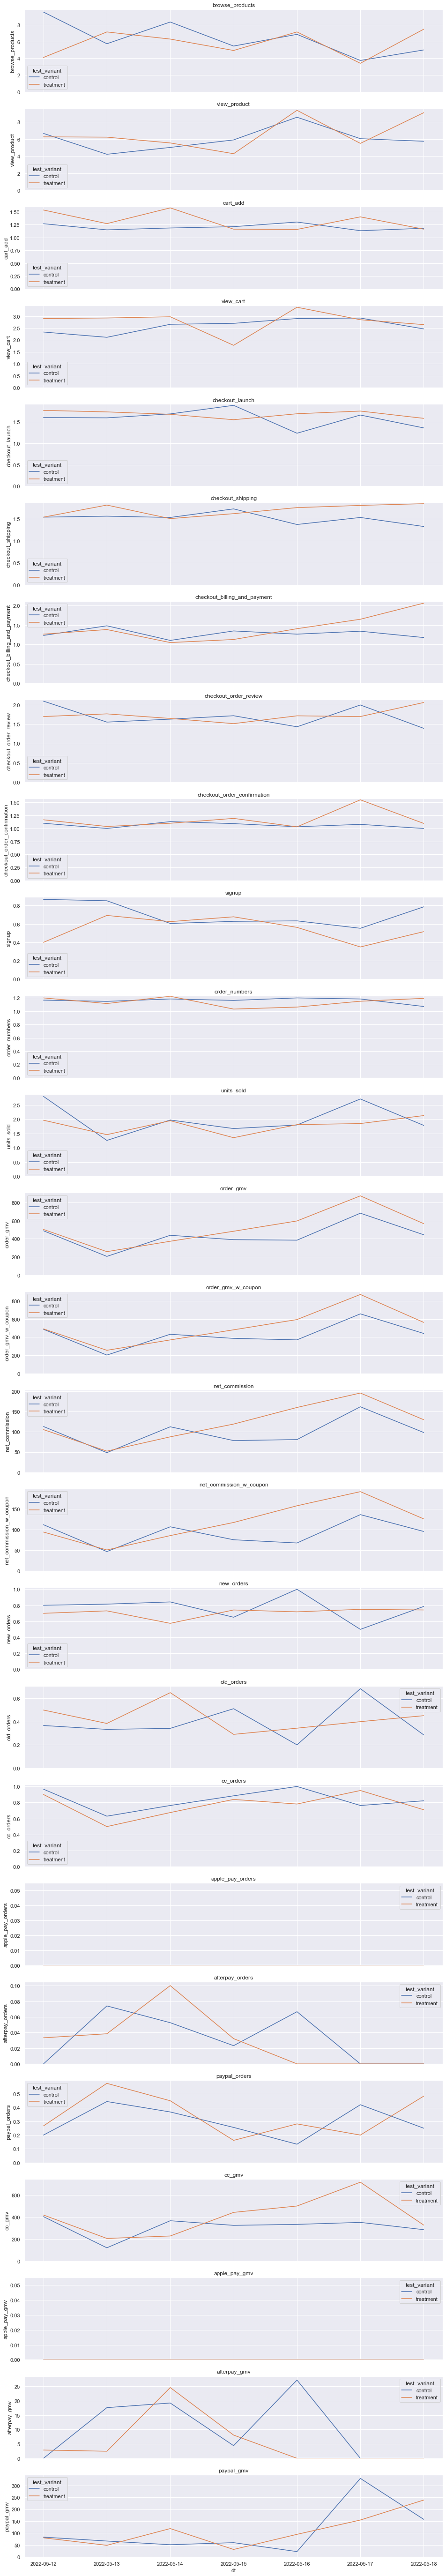

In [29]:
fig, axes = plt.subplots(26, 1, sharex=True, figsize=(16, 100))

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=dtd_metrics, x='dt', y=metric, hue='test_variant')
    axes[i].set_title(metric)
    axes[i].set_ylim(ymin=0)

## Metrics Summary

In [30]:
q = """
select 
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}
where order_gmv < 10000 or order_gmv is null
group by 1, 2
""".format(tmp_final_table=tmp_final_table)

df_all = pd.read_sql(q, conn)

df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,control,39,10,43,56,10,25,10,6,6,7,6,2,7.0,8.0,1584.82,1584.82,384.450,384.450,4.0,3.0,6.0,0.0,0.0,1.0,1387.82,0.0,0.0,197.00
1,treatment,11,13,63,53,13,24,3,2,3,3,2,1,4.0,6.0,1349.66,1349.66,269.960,269.960,1.0,3.0,1.0,0.0,0.0,3.0,635.66,0.0,0.0,714.00
2,treatment,31,22,218,137,25,60,4,9,6,3,2,1,2.0,7.0,725.86,725.86,207.300,207.300,2.0,0.0,1.0,0.0,0.0,1.0,693.00,0.0,0.0,32.86
3,treatment,85,18,134,109,19,32,9,12,5,4,3,3,3.0,3.0,1282.00,1282.00,234.260,234.260,2.0,1.0,2.0,0.0,0.0,1.0,1220.00,0.0,0.0,62.00
4,treatment,84,12,191,123,17,28,4,2,3,6,3,0,2.0,2.0,1238.00,1238.00,222.840,222.840,2.0,0.0,0.0,0.0,0.0,2.0,0.00,0.0,0.0,1238.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,treatment,16,12,64,73,10,34,6,4,2,4,3,2,3.0,5.0,3422.39,3422.39,623.592,623.592,1.0,2.0,2.0,0.0,0.0,1.0,3314.39,0.0,0.0,108.00
196,control,59,14,69,70,14,26,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,treatment,37,12,14,19,5,22,7,7,7,10,3,3,3.0,4.0,233.00,233.00,60.880,60.880,3.0,0.0,2.0,0.0,0.0,1.0,184.00,0.0,0.0,49.00
198,control,68,15,72,106,18,43,11,10,5,4,4,5,5.0,12.0,1484.88,1484.88,324.190,324.190,5.0,0.0,4.0,0.0,0.0,1.0,1070.88,0.0,0.0,414.00


In [31]:
#  fillna metrics with 0
df_all[metrics].isna().sum().sum()
df_all[metrics] = df_all[metrics].fillna(0)

In [32]:
avg_col_list = ['avg_' + m for m in metrics]
df_all[avg_col_list] = df_all[metrics].div(df_all['visitors'], axis=0)
df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,avg_browse_products,avg_view_product,avg_cart_add,avg_view_cart,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_checkout_order_confirmation,avg_signup,avg_order_numbers,avg_units_sold,avg_order_gmv,avg_order_gmv_w_coupon,avg_net_commission,avg_net_commission_w_coupon,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv
0,control,39,10,43,56,10,25,10,6,6,7,6,2,7.0,8.0,1584.82,1584.82,384.450,384.450,4.0,3.0,6.0,0.0,0.0,1.0,1387.82,0.0,0.0,197.00,4.300000,5.600000,1.000000,2.500000,1.000000,0.600000,0.600000,0.700000,0.600000,0.200000,0.700000,0.800000,158.482000,158.482000,38.445000,38.445000,0.400000,0.300000,0.600000,0.0,0.0,0.100000,138.782000,0.0,0.0,19.700000
1,treatment,11,13,63,53,13,24,3,2,3,3,2,1,4.0,6.0,1349.66,1349.66,269.960,269.960,1.0,3.0,1.0,0.0,0.0,3.0,635.66,0.0,0.0,714.00,4.846154,4.076923,1.000000,1.846154,0.230769,0.153846,0.230769,0.230769,0.153846,0.076923,0.307692,0.461538,103.820000,103.820000,20.766154,20.766154,0.076923,0.230769,0.076923,0.0,0.0,0.230769,48.896923,0.0,0.0,54.923077
2,treatment,31,22,218,137,25,60,4,9,6,3,2,1,2.0,7.0,725.86,725.86,207.300,207.300,2.0,0.0,1.0,0.0,0.0,1.0,693.00,0.0,0.0,32.86,9.909091,6.227273,1.136364,2.727273,0.181818,0.409091,0.272727,0.136364,0.090909,0.045455,0.090909,0.318182,32.993636,32.993636,9.422727,9.422727,0.090909,0.000000,0.045455,0.0,0.0,0.045455,31.500000,0.0,0.0,1.493636
3,treatment,85,18,134,109,19,32,9,12,5,4,3,3,3.0,3.0,1282.00,1282.00,234.260,234.260,2.0,1.0,2.0,0.0,0.0,1.0,1220.00,0.0,0.0,62.00,7.444444,6.055556,1.055556,1.777778,0.500000,0.666667,0.277778,0.222222,0.166667,0.166667,0.166667,0.166667,71.222222,71.222222,13.014444,13.014444,0.111111,0.055556,0.111111,0.0,0.0,0.055556,67.777778,0.0,0.0,3.444444
4,treatment,84,12,191,123,17,28,4,2,3,6,3,0,2.0,2.0,1238.00,1238.00,222.840,222.840,2.0,0.0,0.0,0.0,0.0,2.0,0.00,0.0,0.0,1238.00,15.916667,10.250000,1.416667,2.333333,0.333333,0.166667,0.250000,0.500000,0.250000,0.000000,0.166667,0.166667,103.166667,103.166667,18.570000,18.570000,0.166667,0.000000,0.000000,0.0,0.0,0.166667,0.000000,0.0,0.0,103.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,treatment,16,12,64,73,10,34,6,4,2,4,3,2,3.0,5.0,3422.39,3422.39,623.592,623.592,1.0,2.0,2.0,0.0,0.0,1.0,3314.39,0.0,0.0,108.00,5.333333,6.083333,0.833333,2.833333,0.500000,0.333333,0.166667,0.333333,0.250000,0.166667,0.250000,0.416667,285.199167,285.199167,51.966000,51.966000,0.083333,0.166667,0.166667,0.0,0.0,0.083333,276.199167,0.0,0.0,9.000000
196,control,59,14,69,70,14,26,0,0,0,0,0,0,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,4.928571,5.000000,1.000000,1.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
197,treatment,37,12,14,19,5,22,7,7,7,10,3,3,3.0,4.0,233.00,233.00,60.880,60.880,3.0,0.0,2.0,0.0,0.0,1.0,184.00,0.0,0.0,49.00,1.166667,1.583333,0.416667,1.833333,0.583333,0.583333,0.583333,0.833333,0.250000,0.250000,0.250000,0.333333,19.416667,19.416667,5.073333,5.073333,0.250000,0.000000,0.166667,0.0,0.0,0.083333,15.333333,0.0,0.0,4.083333
198,control,68,15,72,106,18,43,11,10,5,4,4,5,5.0,12.0,1484.88,1484.88,324.190,324.190,5.0,0.0,4.0,0.0

In [33]:
df_all.isna().sum().sum()

0

In [34]:
calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_browse_products,1323,9805.000000,7.3887,1330,8948.000000,6.7181,0.67061,9.98%,0.2519
1,avg_view_product,1323,8618.000000,6.6873,1330,7630.000000,5.6874,0.99995,17.58%,0.0501
2,avg_cart_add,1323,1249.000000,0.9737,1330,1169.000000,0.8809,0.09282,10.54%,0.2077
3,avg_view_cart,1323,3133.000000,2.4261,1330,3107.000000,2.3219,0.10416,4.49%,0.3962
4,avg_checkout_launch,1323,689.000000,0.5317,1330,709.000000,0.5302,0.00147,0.28%,0.9709
5,avg_checkout_shipping,1323,678.000000,0.5101,1330,715.000000,0.5286,-0.01853,-3.51%,0.6802
6,avg_checkout_billing_and_payment,1323,446.000000,0.3352,1330,483.000000,0.3542,-0.01897,-5.36%,0.5801
7,avg_checkout_order_review,1323,527.000000,0.4171,1330,548.000000,0.4085,0.00856,2.10%,0.8696
8,avg_checkout_order_confirmation,1323,256.000000,0.1974,1330,268.000000,0.2009,-0.00348,-1.73%,0.8561
9,avg_signup,1323,182.000000,0.1417,1330,237.000000,0.1785,-0.03685,-20.64%,0.0543


# Prepare data to session level to slice by sign in status

In [35]:
pd.read_sql('drop table if exists {tmp_final_table}_by_signinstatus'.format(tmp_final_table=tmp_final_table), conn)

q = """
create table {tmp_final_table}_by_signinstatus AS
with xo as (

select dt, test_variant, visitor_id, signin_status, session_id,

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3, 4, 5

)
, mp as (

select 

		order_date, test_variant, visitor_id,
		session_id,
	
	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3, 4
)
, xo_sign as (

		select dt, visitor_id, session_id, cast(bool_or(cast(isusersignedin as boolean)) as int) + cast(bool_and(cast(isusersignedin as boolean)) as int) as signinstatus_xo
		from {tmp_xo_funnels}
		group by 1, 2, 3

)

select 
		coalesce(order_date, xo.dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		coalesce(mp.session_id, xo.session_id) session_id,
		signin_status,
		signinstatus_xo,
		
		
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
on xo.session_id = mp.session_id
left join xo_sign
on coalesce(mp.session_id, xo.session_id) = xo_sign.session_id

""".format(tmp_xo_metrics=tmp_xo_metrics,
		    tmp_xo_funnels=tmp_xo_funnels,
            tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics
			)

# print(q)
pd.read_sql(q, conn)

,rows
0,7167


In [36]:
df_sign = pd.read_sql('select * from {tmp_final_table}_by_signinstatus'.format(tmp_final_table=tmp_final_table), conn)
df_sign

,dt,test_variant,visitor_id,session_id,signin_status,signinstatus_xo,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-17,control,d7899ee1-7312-4e9a-a2ac-d8f679153338,faddecb3258df526f8faecec4edf541a,SIGNED_OUT,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-18,treatment,aa22c63a-3a75-44f0-b21e-01b0ab2be945,51feb11b3bcbc99d7e084672c9f64246,SIGNED_OUT,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-15,treatment,462b39a3-1ec2-4837-9598-8cfb13daaf6c,65fa69be7d05cfbc1cdc6bfc1209c975,SIGNED_OUT,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-13,control,45633844-f94f-4bad-90f3-c3f108293671,58c3455d69c8c04bb5937bf858b20051,SIGNED_OUT,NaN,10.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-18,treatment,4db0a763-8379-4229-96a4-ed2e78500826,49eaf34c9aed10d75b41399eb63b248f,SIGNED_OUT,NaN,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7162,2022-05-17,treatment,cff33262-5126-485d-8745-28d16fbeddf2,adc7614be8e1e123fa91a62733082869,ALWAYS_SIGNED_IN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7163,2022-05-17,control,ebb47a1e-5777-4fe4-ad26-08865322c451,70e6f0af2eaedcdbb80a5ace3bc6348f,SIGNED_OUT,NaN,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7164,2022-05-18,control,c5fa51a3-b56f-4148-a1e2-30b8f9e0898e,9f16059f86354f8305ae4ac6286b4236,SIGNED_OUT,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7165,2022-05-13,treatment,bf09cf4d-6518-45b2-8717-3f0166284e1a,d24efcd06bfb366cc82904991efcbea1,SIGNED_OUT,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# two fields not completely corelated
df_sign[['signin_status', 'signinstatus_xo']].drop_duplicates()

,signin_status,signinstatus_xo
0,SIGNED_OUT,NaN
5,ALWAYS_SIGNED_IN,NaN
7,PARTIAL_SIGNED_IN,1.0
14,PARTIAL_SIGNED_IN,NaN
22,SIGNED_IN_MULTIPLE,0.0
...,...,...
90,PARTIAL_SIGNED_IN,2.0
163,SIGNED_IN_MULTIPLE,2.0
423,SIGNED_IN_MULTIPLE,NaN
712,None,NaN


## Slice by session level signin status

In [38]:
# prepare data by slicing `signin_status`
q = """
select 
        signin_status, 
		--signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_sign_ss = pd.read_sql(q, conn)

df_sign_ss

,signin_status,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,PARTIAL_SIGNED_IN,control,93,4,35.0,28.0,2.0,7.0,4.0,4.0,3.0,1.0,1.0,2.0,3.0,5.0,224.00,224.00,9.623,9.623,3.0,0.0,3.0,0.0,0.0,0.0,224.00,0.0,0.0,0.00
1,SIGNED_OUT,treatment,69,16,73.0,73.0,17.0,39.0,8.0,10.0,2.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SIGNED_OUT,treatment,81,11,36.0,39.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SIGNED_OUT,treatment,92,6,4.0,25.0,5.0,21.0,4.0,4.0,6.0,7.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SIGNED_OUT,control,12,3,10.0,9.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,SIGNED_OUT,treatment,49,9,53.0,58.0,5.0,25.0,8.0,4.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
682,SIGNED_OUT,treatment,32,10,103.0,136.0,15.0,29.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
683,PARTIAL_SIGNED_IN,control,21,5,21.0,11.0,3.0,5.0,5.0,7.0,6.0,6.0,3.0,4.0,3.0,3.0,1888.98,1888.98,517.690,517.690,2.0,1.0,2.0,0.0,0.0,1.0,203.99,0.0,0.0,1684.99
684,ALWAYS_SIGNED_IN,control,58,5,43.0,79.0,0.0,9.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_sign_ss[metrics].isna().sum()
df_sign_ss[metrics] = df_sign_ss[metrics].fillna(0)

In [41]:
def metricSummary(df):
    df[metrics] = df[metrics].fillna(0)
    df[avg_col_list] = df[metrics].div(df['visitors'], axis=0)
    # metricSum = calculate(df, avg_col_list, control, treatment).reset_index()\
    # .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)
    # return metricSum
    return calculate(df, avg_col_list, control, treatment)#.reset_index()#\
    #.drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)


In [42]:
# df_sign_ss.groupby('signin_status').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', 10)
df_sign_ss.groupby('signin_status').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

## Slice by signin status upon checkout

In [43]:
# prepare data by slicing `signin_status during xo`
q = """
select 
        --signin_status, 
		signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from {tmp_final_table}_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_sign_xo = pd.read_sql(q, conn)

df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2.0,control,8,4,10,46,11,18,6,3,2,15,3,0,3.0,10.0,6745.99,6745.99,2156.08,2156.08,1.0,2.0,3.0,0.0,0.0,0.0,6745.99,0.0,0.0,0.0
1,NaN,control,46,14,86,108,28,35,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,treatment,2,10,91,37,7,11,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,treatment,2,3,42,78,13,16,4,4,4,1,1,0,1.0,1.0,49.00,49.00,8.24,8.24,0.0,1.0,1.0,0.0,0.0,0.0,49.00,0.0,0.0,0.0
4,2.0,control,66,3,43,23,4,7,8,4,7,2,6,0,2.0,5.0,1551.88,1551.88,279.34,279.34,0.0,2.0,2.0,0.0,0.0,0.0,1551.88,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,1.0,treatment,10,1,1,2,1,2,4,4,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578,NaN,treatment,15,8,96,42,9,10,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579,NaN,control,65,7,119,29,10,12,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
580,0.0,treatment,15,5,49,32,7,17,11,12,8,24,3,3,2.0,5.0,789.12,789.12,142.09,142.09,2.0,0.0,2.0,0.0,0.0,0.0,789.12,0.0,0.0,0.0


In [44]:
df_sign_xo['signinstatus_xo'].value_counts()

0.0    185
2.0    142
1.0     55
Name: signinstatus_xo, dtype: int64

In [45]:
df_sign_xo['signinstatus_xo'].replace({0.0:'Never signin', 1.0:'Signin during XO', 2.0:'Always signin'}, inplace=True)
df_sign_xo['signinstatus_xo'].fillna('Did not checkout', inplace=True)

In [46]:
df_sign_xo[metrics].isna().sum()

browse_products      0
view_product         0
cart_add             0
view_cart            0
checkout_launch      0
                  ... 
paypal_orders      297
cc_gmv             297
apple_pay_gmv      297
afterpay_gmv       297
paypal_gmv         297
Length: 26, dtype: int64

In [47]:
df_sign_xo[metrics] = df_sign_xo[metrics].fillna(0)

In [48]:
df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,Always signin,control,8,4,10,46,11,18,6,3,2,15,3,0,3.0,10.0,6745.99,6745.99,2156.08,2156.08,1.0,2.0,3.0,0.0,0.0,0.0,6745.99,0.0,0.0,0.0
1,Did not checkout,control,46,14,86,108,28,35,0,0,0,0,0,1,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,Did not checkout,treatment,2,10,91,37,7,11,0,0,0,0,0,1,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,Never signin,treatment,2,3,42,78,13,16,4,4,4,1,1,0,1.0,1.0,49.00,49.00,8.24,8.24,0.0,1.0,1.0,0.0,0.0,0.0,49.00,0.0,0.0,0.0
4,Always signin,control,66,3,43,23,4,7,8,4,7,2,6,0,2.0,5.0,1551.88,1551.88,279.34,279.34,0.0,2.0,2.0,0.0,0.0,0.0,1551.88,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,Signin during XO,treatment,10,1,1,2,1,2,4,4,2,2,0,0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
578,Did not checkout,treatment,15,8,96,42,9,10,0,0,0,0,0,0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
579,Did not checkout,control,65,7,119,29,10,12,0,0,0,0,0,0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
580,Never signin,treatment,15,5,49,32,7,17,11,12,8,24,3,3,2.0,5.0,789.12,789.12,142.09,142.09,2.0,0.0,2.0,0.0,0.0,0.0,789.12,0.0,0.0,0.0


In [49]:
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', None)
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)